In [1]:
import netket as nk
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax,sigmaz,sigmay,identity,sigmam,sigmap   
import flax
import jax
import jax.numpy as jnp
import flax.linen as nn
from scipy.sparse.linalg import eigsh 
from netket import nn as nknn
from Methods.class_WF import Diag
import Methods.class_WF as class_WF
import Methods.var_nk as var_nk
import os
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib as mpl
import numpy as np
import sys
import pandas as pd
import equinox as eqx
import os
from matplotlib import cm
import matplotlib as mp
import matplotlib.colors as mcolors
import scipy.special as sc
import scipy.optimize as so
from matplotlib.colors import LinearSegmentedColormap
from functools import reduce

In [2]:
#DEFINE FUNCTIONS:

In [3]:
from Methods.class_WF import rotated_sigmax, rotated_sigmaz,isigmay,rotated_IsingModel
from Methods.class_WF import rotated_XYZModel, parity_Matrix, parity_IsingModel, Sz0Szj, Sx0Sxj, to_array



In [4]:
#DEFINE THE VARIABLES:

In [420]:
L=10
NS=2048
G=30
DG=0.01
NN=1
NL=1
NR=5000
learning_rate=0.05
basis="QIM"
modelo="RBM_REAL"

if modelo=="RBM_COMPLEX":
    model=nk.models.RBM(alpha=NN,param_dtype=complex)
    sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)
elif modelo=="RBM_REAL":
    model=nk.models.RBM(alpha=NN)
    sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=False)

angle=0
Nangle=4
dangle=np.pi/(2*Nangle)

NSPCA=10
MASTER_DIR="RUN_QIM_"+modelo+"NN"+str(NN)+"L"+str(L)+"G"+str(G)
Nstates=2**L
eps=10**(-10)
angle=[dangle*i for i in range(Nangle+1)]
num_states=[i for i in range(2**L)]
try:
    os.mkdir(MASTER_DIR)
except:
    print("DIRECTORY ALREADY CREATED")
OBS_FILENAME="NANGLE"+str(Nangle)+basis+"M3L"+str(L)+"W1"+"G"+str(G)+"NS"+str(NS)+"NN"+str(NN)+"NL"+str(NL)+"NR"+str(NR)+"OBS"
SPCA_FILENAME="NANGLE"+str(Nangle)+basis+"M3L"+str(L)+"W1"+"G"+str(G)+"NS"+str(NS)+"NN"+str(NN)+"NL"+str(NL)+"NR"+str(NR)+"SPCA"
VAR_FILENAME="NANGLE"+str(Nangle)+basis+"M3L"+str(L)+"W1"+"G"+str(G)+"NS"+str(NS)+"NN"+str(NN)+"NL"+str(NL)+"NR"+str(NR)+"VAR"

In [421]:
norm = mcolors.Normalize(vmin=np.abs(0), vmax=1)
colors = [(0.0, 'yellow'),(0.25, "green"),(0.5, 'blue'),(0.75,"brown"),(1.0, 'red')]
cmap = LinearSegmentedColormap.from_list('custom_blue_green', colors)

In [422]:
#EXACT DIAGONALIZATION AND COMPUTING THE ORDER PARAMETER

In [423]:
#SOLUTION OF THE ISING MODEL AS A FUNCTION OF THETA:

In [424]:
#SOLUTION OF THE ISING MODEL AND ITS PARAMETERS...

In [425]:
S_PCA_TEO=[0.0 for i in angle]
PSI_TEO=[None for i in angle]
hi=nk.hilbert.Spin(s=1/2,N=L)
states=hi.all_states()
for theta in range(len(angle)):
    H=rotated_IsingModel(angle[theta],G*DG,L,hi)
    eig_vals_other,eig_vecs_other=np.linalg.eigh(H.to_dense())
    PSI_TEO[theta]=eig_vecs_other[:,0]
    A=np.random.choice(num_states,size=1000,p=eig_vecs_other[:,0]**2)
    B=np.array([states[a] for a in A])
    S_PCA_TEO[theta]=class_WF.S_PCA(B,10**(-10),exvar=False)
    
sisj_z=[ eig_vecs_other[:,0].T@Sz0Szj(0.0,L,hi,j).to_dense()@eig_vecs_other[:,0] for j in [1,int(L/2),L-1]]
sisj_x=[ eig_vecs_other[:,0].T@Sx0Sxj(0.0,L,hi,j).to_dense()@eig_vecs_other[:,0] for j in [1,int(L/2),L-1]]



In [426]:
# INITIALIZE NETKET TOOLS
sites_corr=[1,int(L/2),L-1]
sites_corr=[str(x) for x in sites_corr]
S=[ None for i in range(len(angle))]
E=[None for i in range(len(angle))]
dE=[None for i in range(len(angle))]
P=[None for i in range(len(angle))]
dP=[None for i in range(len(angle))]


CZ=[ [None for corr in sites_corr] for i in range(len(angle))]
dCZ=[ [None for corr in sites_corr] for i in range(len(angle))]

CX=[ [None for corr in sites_corr] for i in range(len(angle))]
dCX=[ [None for corr in sites_corr] for i in range(len(angle))]

for ii in range(len(angle)):
    if angle[ii]==np.pi/(2.0):
        hi=nk.hilbert.Spin(s=1/2,N=L,constraint=class_WF.ParityConstraint())
    else:
        hi=nk.hilbert.Spin(s=1/2,N=L,constraint=class_WF.ParityConstraint())

    H=rotated_IsingModel(angle[ii],G*DG,L,hi)

    alpha=1
    learning_rate=0.05
    g = nk.graph.Hypercube(length=L, n_dim=1, pbc=False)
    #sampler = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
    sampler=nk.sampler.MetropolisHamiltonian(hi, hamiltonian=H)
    #sampler=nk.sampler.MetropolisLocal(hi,n_chains=128,sweep_size=50)
    vstate=nk.vqs.MCState(sampler,model,n_samples=NS)
    optimizer=nk.optimizer.Sgd(learning_rate=learning_rate)
    PSI=class_WF.WF(L,hi,sampler,sr,model,H,NS)
    
    log = nk.logging.RuntimeLog()
    log2 = nk.logging.RuntimeLog()
    log3 = nk.logging.RuntimeLog()
    #OBSERVABLES INIT.
    obs={}
    obs["P"]=parity_IsingModel(angle[ii],L,hi)
    for jj in sites_corr:
        obs["CZ0"+jj]=Sz0Szj(angle[ii],L,hi,int(jj))
        obs["CX0"+jj]=Sx0Sxj(angle[ii],L,hi,int(jj))

    NR_eff=int(NR/NSPCA)
    for kk in range(NSPCA):
        PSI.run(obs=obs,n_iter=NR_eff,log=log)
        PSI.save_params(kk,log2)
        if ii!=0:
            broken_z2=False
        else:
            broken_z2=True
            
        PSI.compute_PCA(10**(-8),i=kk,log=log3,broken_z2=broken_z2)
        
        
    log2.serialize(MASTER_DIR+"/"+str(ii)+VAR_FILENAME)
    log.serialize(MASTER_DIR+"/"+str(ii)+OBS_FILENAME)
    log3.serialize(MASTER_DIR+"/"+str(ii)+SPCA_FILENAME)
    
    data_RBM = log.data
    param_RBM = log2.data
    data_S_PCA =  log3.data

    E[ii]=np.real(data_RBM["Energy"].Mean)
    dE[ii]=np.real(data_RBM["Energy"].Sigma)
    P[ii]=np.real(data_RBM["P"].Mean)
    dP[ii]=np.real(data_RBM["P"].Sigma)
    S[ii]=np.real(data_S_PCA["Mean"].value)
    
    for xi in range(len(sites_corr)):
        CZ[ii][xi]=np.real(data_RBM["CZ0"+sites_corr[xi]].Mean)
        dCZ[ii][xi]=np.real(data_RBM["CZ0"+sites_corr[xi]].Sigma)
        CX[ii][xi]=np.real(data_RBM["CX0"+sites_corr[xi]].Mean)
        dCX[ii][xi]=np.real(data_RBM["CX0"+sites_corr[xi]].Sigma)


  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

In [427]:
# ENERGY

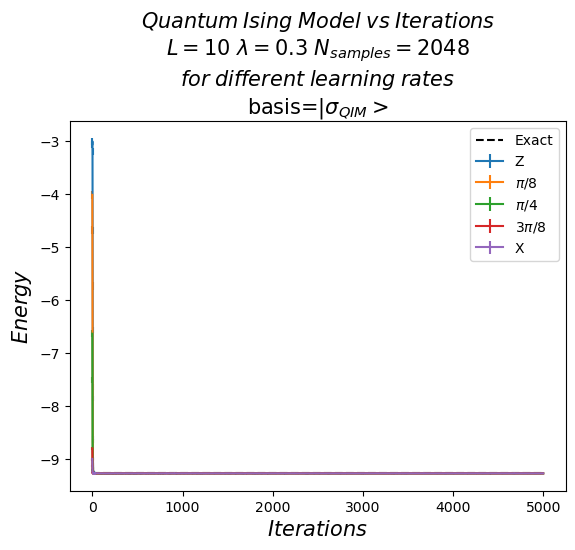

In [428]:
labels=["Z",r"$\pi/8$",r"$\pi/4$",r"$3\pi/8$","X"]
plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$for\;different\;learning\;rates$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
for i in range(len(labels)):
    plt.errorbar(data_RBM["Energy"].iters,E[i],yerr=dE[i],label=labels[i])
plt.hlines([eig_vals_other[0]], xmin=0, xmax=NR, color="black",linestyle="dashed",label="Exact")
plt.legend()
plt.xlabel("$Iterations$",fontsize=15)
plt.ylabel("$Energy$",fontsize=15)
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")

/tmp/ipykernel_82325/2557738717.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(1/data_RBM["Energy"].iters,np.abs((E[i]-eig_vals_other[0])/eig_vals_other[0]),yerr=np.abs(dE[i]/eig_vals_other[0]),marker="*",label=labels[i])


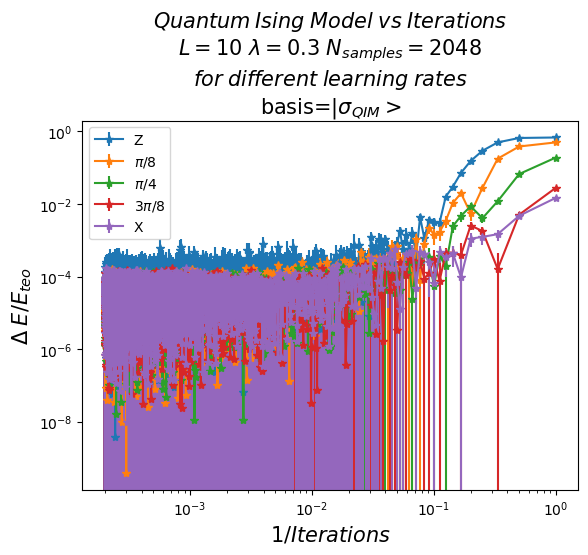

In [429]:
plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$for\;different\;learning\;rates$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
for i in range(len(labels)):
    plt.errorbar(1/data_RBM["Energy"].iters,np.abs((E[i]-eig_vals_other[0])/eig_vals_other[0]),yerr=np.abs(dE[i]/eig_vals_other[0]),marker="*",label=labels[i])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$1/Iterations$",fontsize=15)
plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=15)
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")

/tmp/ipykernel_82325/165974961.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(1/data_RBM["Energy"].iters,np.abs((E[i]-eig_vals_other[0])/eig_vals_other[0]),marker="*",label=labels[i])


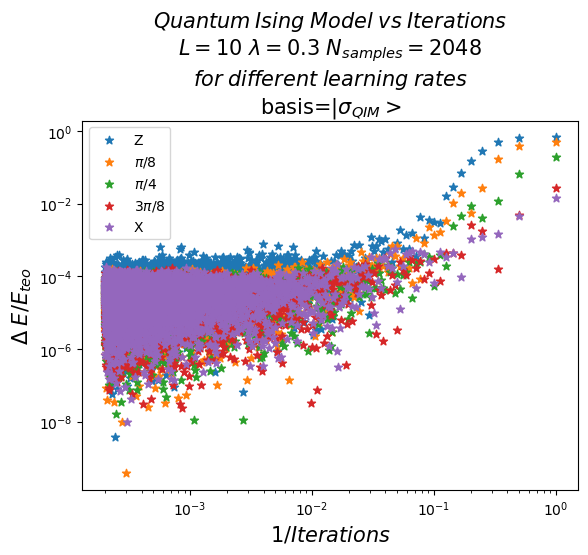

In [430]:
plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$for\;different\;learning\;rates$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
for i in range(len(labels)):
    plt.scatter(1/data_RBM["Energy"].iters,np.abs((E[i]-eig_vals_other[0])/eig_vals_other[0]),marker="*",label=labels[i])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$1/Iterations$",fontsize=15)
plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=15)
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")

/tmp/ipykernel_82325/1718642556.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(1/data_RBM["Energy"].iters,E[i]-eig_vals_other[0],yerr=dE[i],marker="*",label=labels[i])


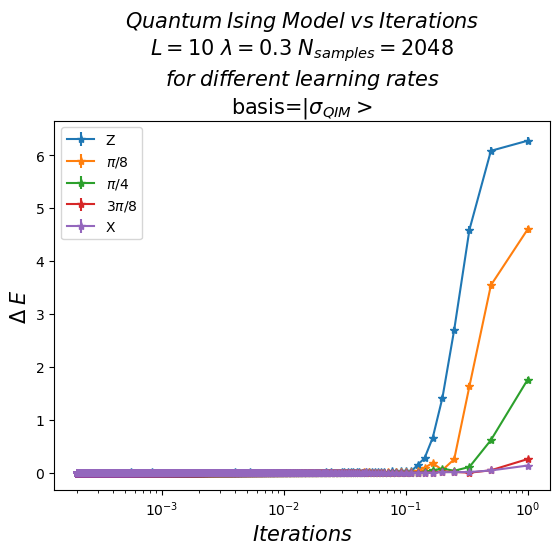

In [431]:
plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$for\;different\;learning\;rates$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
for i in range(len(labels)):
    plt.errorbar(1/data_RBM["Energy"].iters,E[i]-eig_vals_other[0],yerr=dE[i],marker="*",label=labels[i])
plt.legend()
plt.xscale("log")
plt.xlabel("$Iterations$",fontsize=15)
plt.ylabel(r"$\Delta\;E$",fontsize=15)
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")

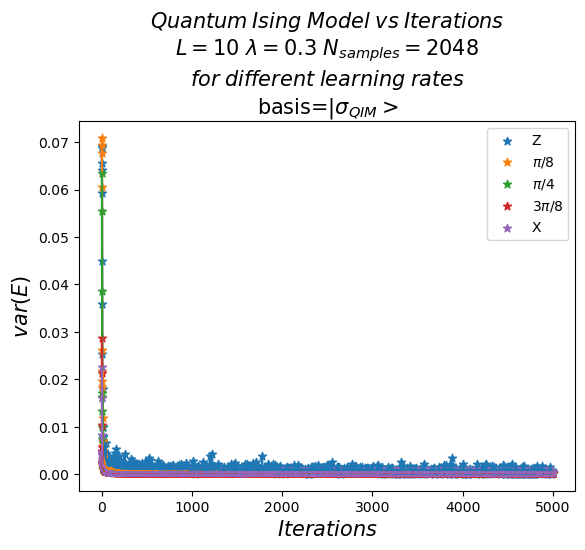

In [432]:
plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$for\;different\;learning\;rates$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
for i in range(len(labels)):
    plt.scatter(data_RBM["Energy"].iters,dE[i],marker="*",label=labels[i])
    plt.plot(data_RBM["Energy"].iters,dE[i])
plt.legend()
#plt.yscale("log")
plt.xlabel("$Iterations$",fontsize=15)
plt.ylabel(r"$var(E)$",fontsize=15)
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")

In [433]:
# S_PCA

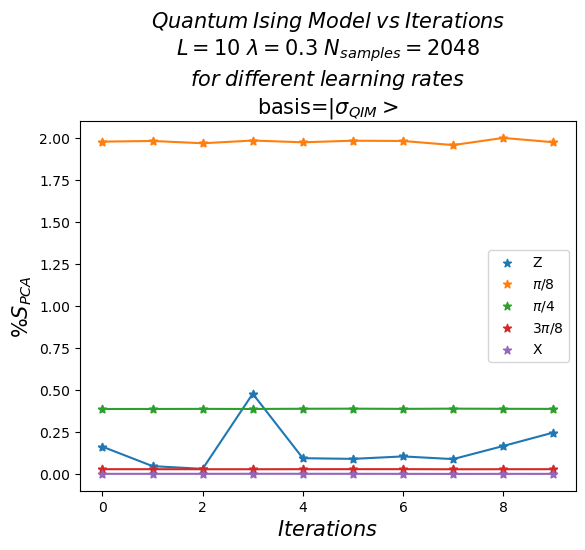

In [434]:
plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$for\;different\;learning\;rates$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
for i in range(len(labels)):
    plt.plot(data_S_PCA["Mean"].iters,np.abs((S[i]-S_PCA_TEO[i])/S_PCA_TEO[i]),marker="*")
    plt.scatter(data_S_PCA["Mean"].iters,np.abs((S[i]-S_PCA_TEO[i])/S_PCA_TEO[i]),label=labels[i],marker="*")
plt.legend()
plt.xlabel("$Iterations$",fontsize=15)
plt.ylabel(r"$\% S_{PCA}$",fontsize=15)
plt.savefig(MASTER_DIR+"/"+str(i)+"PCA_BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")
plt.show()

In [435]:
# PARITY

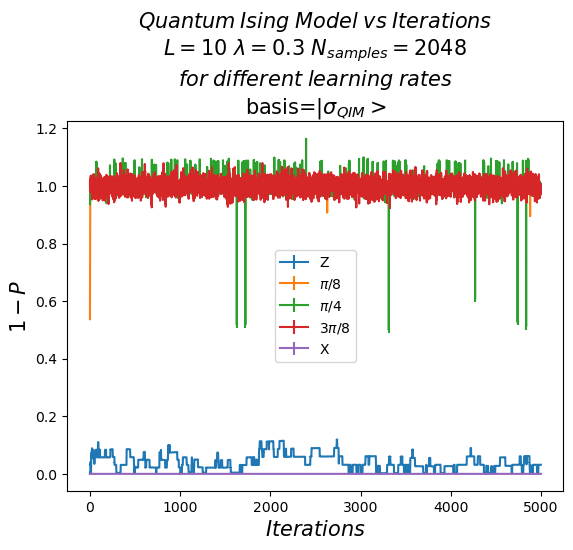

In [436]:
plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$for\;different\;learning\;rates$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
for i in range(len(labels)):
    plt.errorbar(data_RBM["P"].iters,np.abs(1-P[i]),yerr=dP[i]/np.sqrt(NS),label=labels[i])
plt.legend()
plt.xlabel("$Iterations$",fontsize=15)
plt.ylabel("$1-P$",fontsize=15)
#plt.yscale("log")
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")

In [437]:
#CORRELATIONS...

/tmp/ipykernel_82325/285462839.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(1/data_RBM["P"].iters,np.abs(sisj_z[j]-CZ[i][j]),yerr=np.abs(dCZ[i][j])/np.sqrt(NS),label=labels[i])


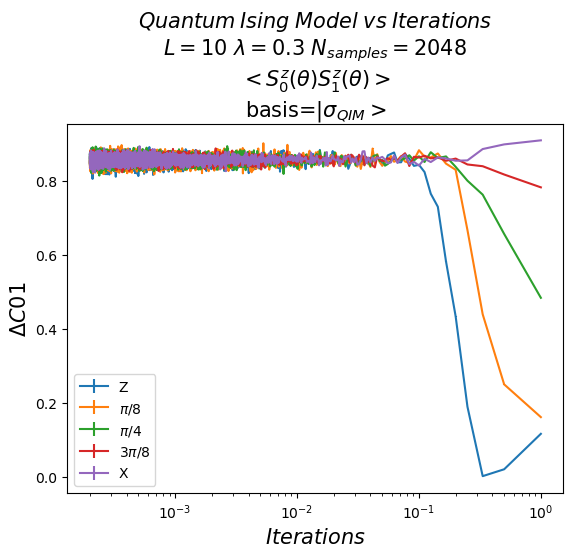

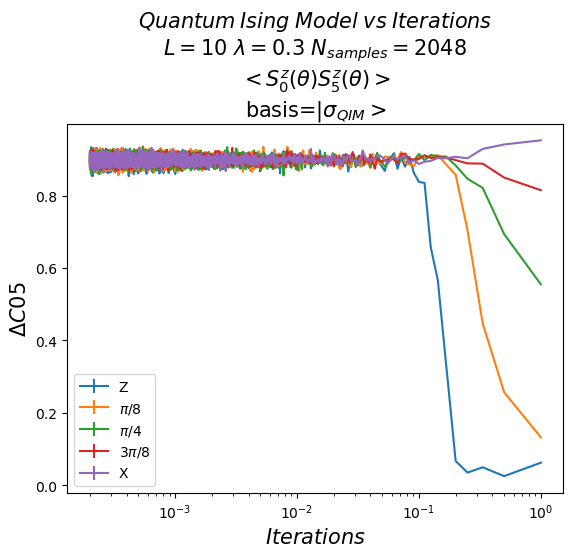

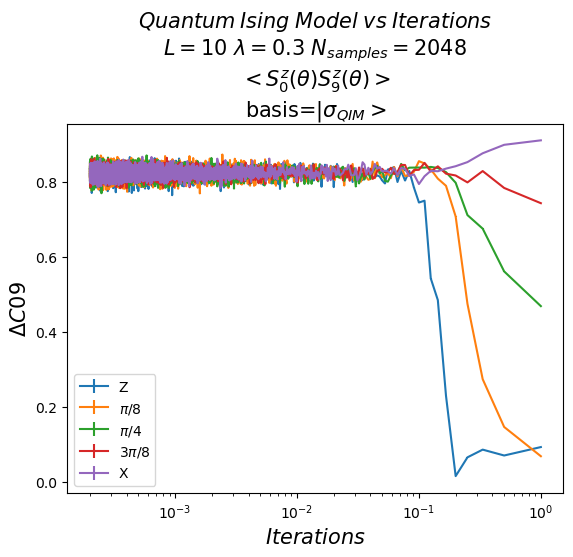

In [438]:

for j in range(len(sites_corr)):
    plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$<S_0^z(\theta)S_"+sites_corr[j]+r"^z(\theta)>$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
    plt.xlabel("$Iterations$",fontsize=15)
    plt.ylabel(r"$"+r"\Delta C0"+sites_corr[j]+"$",fontsize=15)
    #plt.yscale("log")
    plt.xscale("log")
    for i in range(len(labels)):
        plt.errorbar(1/data_RBM["P"].iters,np.abs(sisj_z[j]-CZ[i][j]),yerr=np.abs(dCZ[i][j])/np.sqrt(NS),label=labels[i])
    plt.legend()
    plt.savefig(MASTER_DIR+"/"+str(i)+"-"+str(j)+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")
    plt.show()

/tmp/ipykernel_82325/3754225770.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(1/data_RBM["P"].iters,(CZ[i][j]-sisj_z[j]),yerr=(dCZ[i][j])/np.sqrt(NS),label=labels[i])


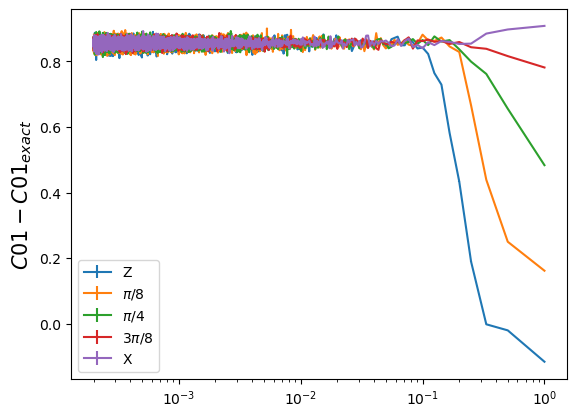

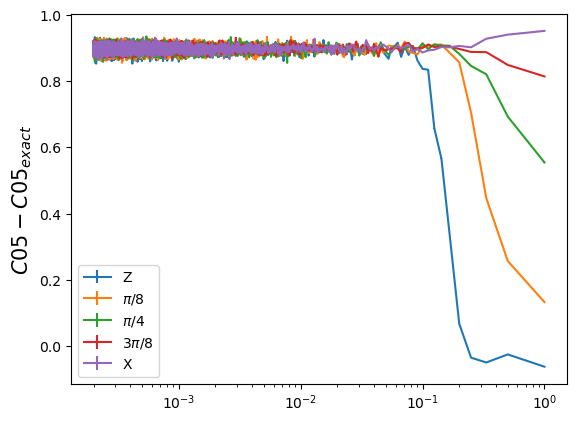

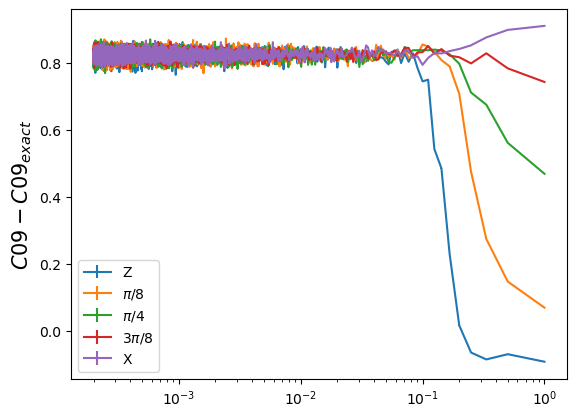

In [439]:
for j in range(len(sites_corr)):
    #plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$<S_0^z(\theta)S_"+sites_corr[j]+r"^z(\theta)>$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
    #plt.xlabel("$1/Iterations$",fontsize=15)
    plt.ylabel("$"+"C0"+sites_corr[j]+"-C0"+sites_corr[j]+"_{exact}$",fontsize=15)
    plt.xscale("log")
    for i in range(len(labels)):
        plt.errorbar(1/data_RBM["P"].iters,(CZ[i][j]-sisj_z[j]),yerr=(dCZ[i][j])/np.sqrt(NS),label=labels[i])
    plt.legend()
    plt.savefig(MASTER_DIR+"/"+"NP"+str(i)+"-"+str(j)+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")
    plt.show()

In [440]:
# X basis

/tmp/ipykernel_82325/3246736481.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(1/data_RBM["P"].iters,np.abs(sisj_x[j]-CX[i][j]),yerr=np.abs(dCX[i][j])/np.sqrt(NS),label=labels[i])


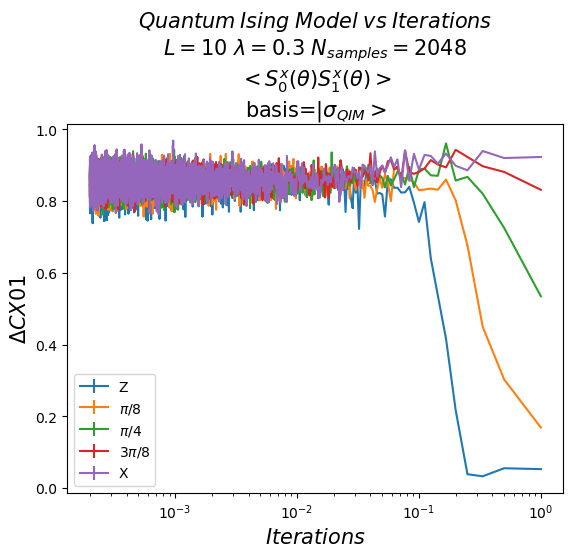

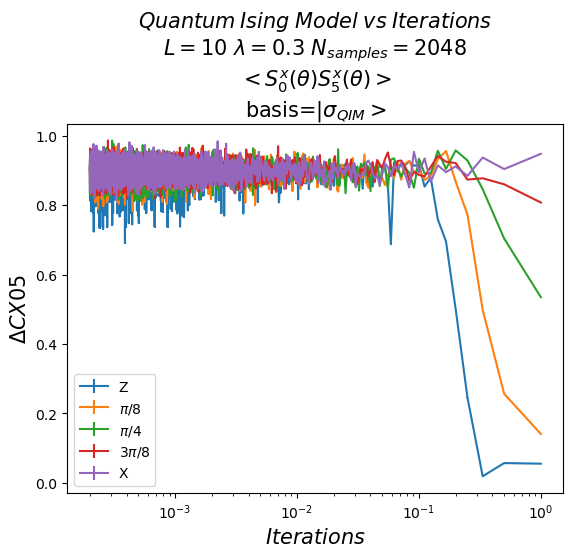

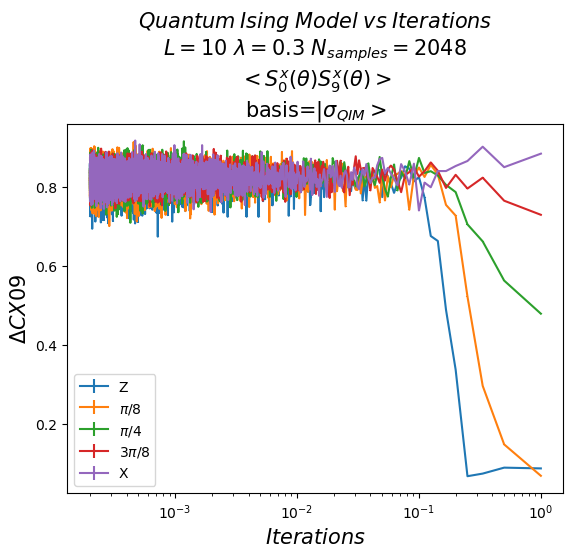

In [441]:

for j in range(len(sites_corr)):
    plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$<S_0^x(\theta)S_"+sites_corr[j]+r"^x(\theta)>$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
    plt.xlabel("$Iterations$",fontsize=15)
    plt.ylabel(r"$"+r"\Delta CX0"+sites_corr[j]+"$",fontsize=15)
    #plt.yscale("log")
    plt.xscale("log")
    for i in range(len(labels)):
        plt.errorbar(1/data_RBM["P"].iters,np.abs(sisj_x[j]-CX[i][j]),yerr=np.abs(dCX[i][j])/np.sqrt(NS),label=labels[i])
    plt.legend()
    plt.savefig(MASTER_DIR+"/"+str(i)+"-"+str(j)+"BASISX"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")
    plt.show()

/tmp/ipykernel_82325/202788692.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(1/data_RBM["P"].iters,(CX[i][j]-sisj_x[j]),yerr=(dCX[i][j])/np.sqrt(NS),label=labels[i])


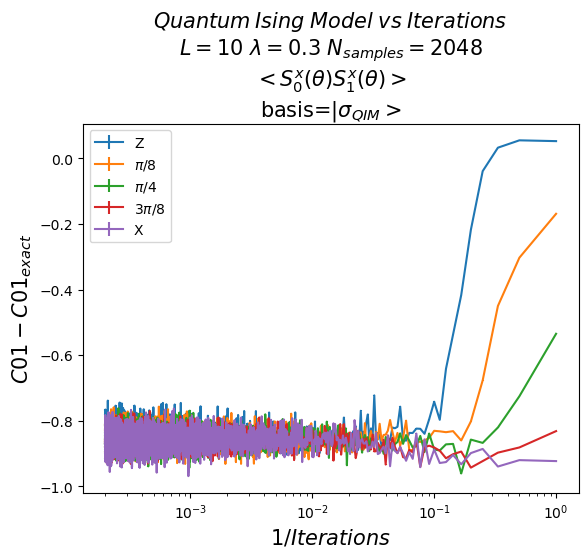

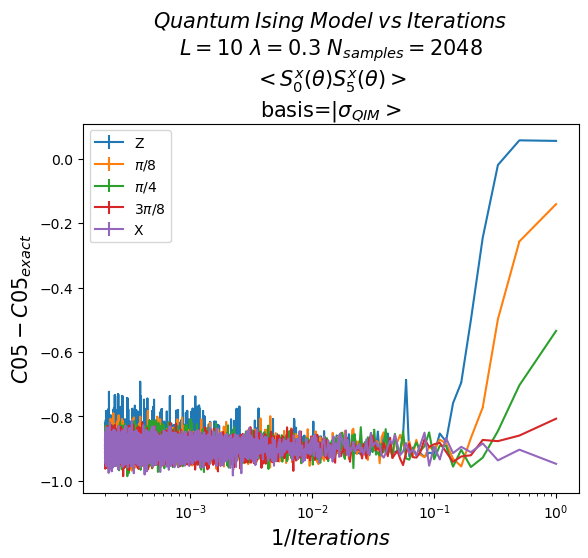

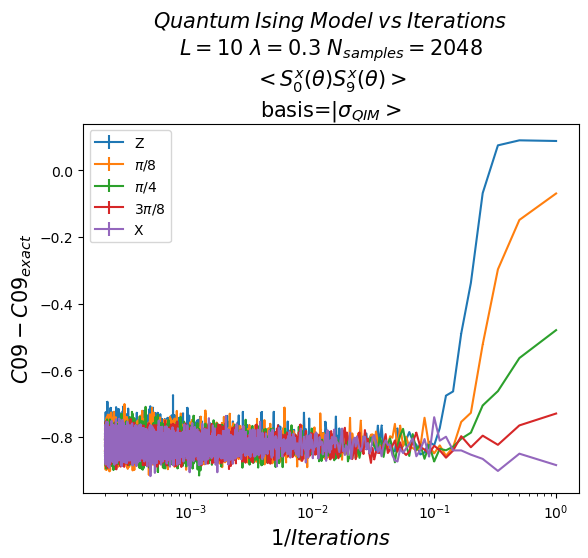

In [442]:
for j in range(len(sites_corr)):
    plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+" $N_{samples}="+str(NS)+"$"+"\n"+r"$<S_0^x(\theta)S_"+sites_corr[j]+r"^x(\theta)>$"+"\n"+r"basis=$|\sigma_{"+basis+r"}>$",fontsize=15)
    plt.xlabel("$1/Iterations$",fontsize=15)
    plt.ylabel("$"+"C0"+sites_corr[j]+"-C0"+sites_corr[j]+"_{exact}$",fontsize=15)
    plt.xscale("log")
    for i in range(len(labels)):
        plt.errorbar(1/data_RBM["P"].iters,(CX[i][j]-sisj_x[j]),yerr=(dCX[i][j])/np.sqrt(NS),label=labels[i])
    plt.legend()
    plt.savefig(MASTER_DIR+"/"+"NP"+str(i)+"-"+str(j)+"BASISX"+basis+"L"+str(L)+"G"+str(G)+"NS"+str(NS)+"DIF_LEARNING_RATES.png")
    plt.show()

In [443]:
#Way to get DATA from json files:

import json

# Load the data from the JSON file
with open("help.json", "r") as f:
    data = json.load(f)

# Print the data to inspect its structure
print(data["P"]["Mean"])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [444]:
#PARAMETERS EVOLUTION IN THE RBM
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [445]:
import json

data=[None for i in range(len(angle))]
# Load the data from the JSON file
for i in range(len(angle)):
    with open(MASTER_DIR+"/"+str(i)+VAR_FILENAME+".json", "r") as f:
        data[i] = json.load(f)

# Print the data to inspect its structure


In [446]:
Y = np.arange(0, NSPCA , 1)  # Y values (columns)


In [447]:
ang=4
param_RBM=data[ang]

In [448]:
labels=[r"$visible\;bias$",r"$dense\;bias$",r"$kernel$"]
labels_name=["visible_bias","dense_bias","kernel"]
label_par=[r"$a_i$",r"$b_i$",r"$k_{ij}$"]
Z=[np.array(param_RBM["params"]["visible_bias"]["value"]),np.array(param_RBM["params"]["Dense"]["bias"]["value"]),np.array(param_RBM["params"]["Dense"]["kernel"]["value"])]
Z[2]=Z[2].reshape(-1,Z[2].shape[-1])

10 10
10 10
100 100


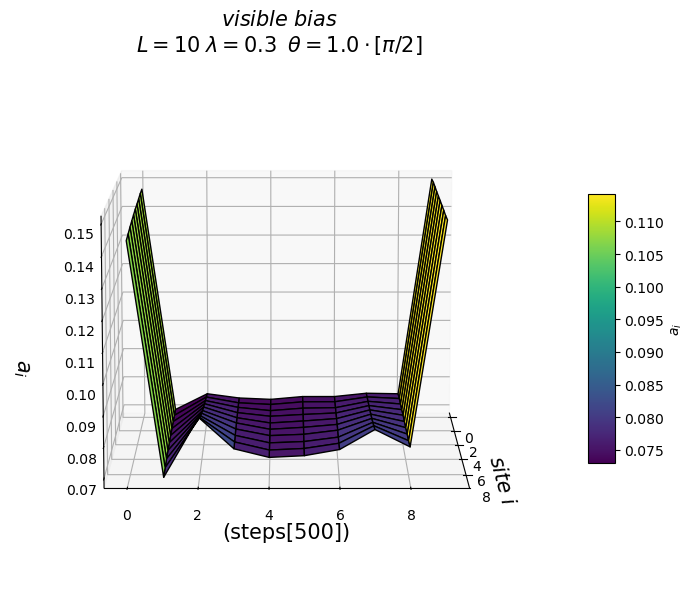

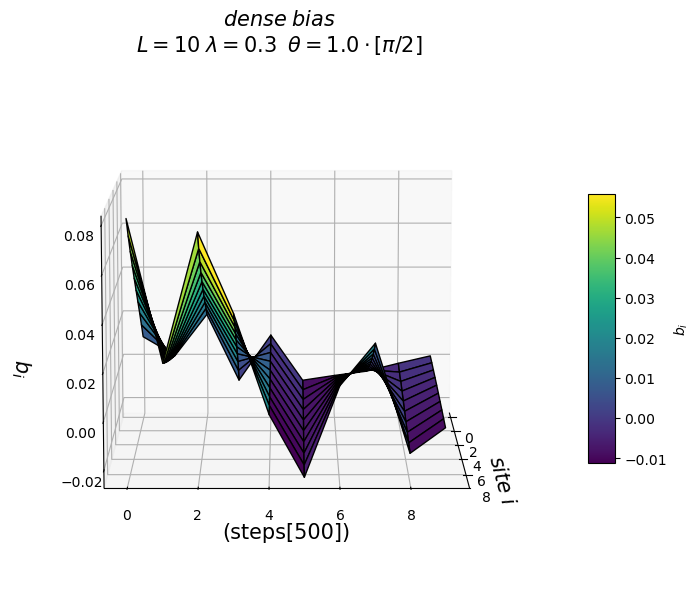

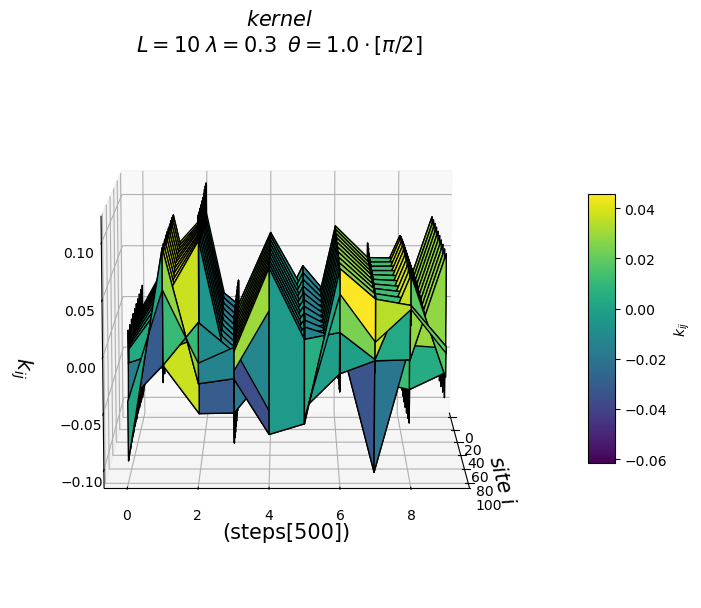

In [449]:
# Create the 3D figure
for i in range(len(label_par)):

    X = np.arange(0,len(Z[i]), 1)  # X values (rows)
    print(len(Z[i]),len(X))
    X_mesh, Y_mesh = np.meshgrid(X, Y)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X_mesh, Y_mesh, Z[i].T, cmap='viridis', edgecolor='k')
    # Add a color bar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.05)
    cbar.set_label(label_par[i])
    # Labels and title
    ax.set_xlabel(r"$site\;i$ ",fontsize=15)
    ax.set_ylabel("(steps["+str(int(NR/NSPCA))+"])",fontsize=15)
    ax.set_zlabel(label_par[i], labelpad=20,fontsize=15) 
    ax.set_title(labels[i]+"\n"+"$L="+str(L)+r"\;\lambda="+str(round(G*DG,1))+r"\;\;\theta="+str(angle[ang]/(np.pi/2))+r"\cdot [\pi/2]$",fontsize=15)
    ax.view_init(elev=10, azim=0)  # Adjust angles (elevation=45°, azimuth=120°)
    plt.savefig(MASTER_DIR+"/"+"theta"+str(ang)+labels_name[i]+"L"+str(L)+"G"+str(G)+".png")

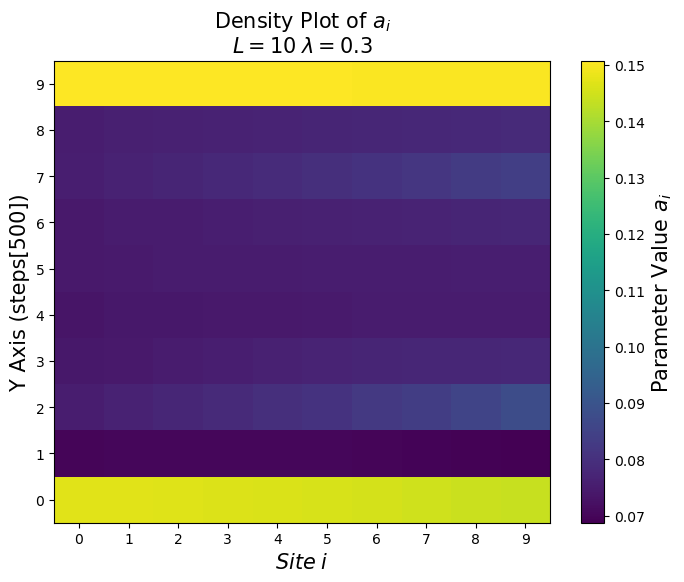

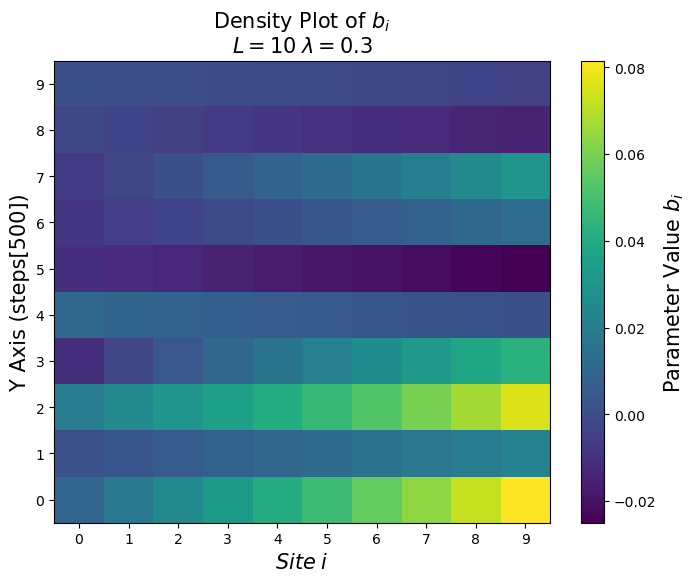

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (100).

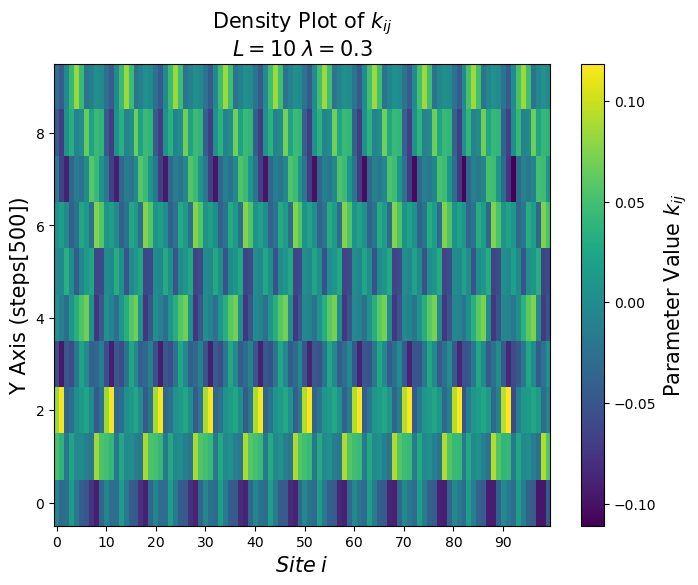

In [450]:

# Plot the heatmap
for i in range(len(label_par)):
    fig, ax = plt.subplots(figsize=(8, 6))
    X = np.arange(0,len(Z[i]), 1)  # X values (rows)
    c = ax.imshow(Z[i].T, cmap='viridis', aspect='auto', origin='lower')

# Add a colorbar
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label("Parameter Value "+label_par[i],fontsize=15)

# Labels and title
    ax.set_xlabel(r"$Site \;i$",fontsize=15)
    ax.set_ylabel("Y Axis (steps["+str(int(NR/NSPCA))+"])",fontsize=15)
    ax.set_title(r"Density Plot of "+label_par[i]+"\n"+"$L="+str(L)+r"\;\lambda="+str(round(G*DG,1))+"$",fontsize=15)

# Set tick labels
    ax.set_xticks(np.arange(0,len(X),len(X)/NSPCA))
    ax.set_xticklabels(X)
    ax.set_yticks(np.arange(len(Y)))
    ax.set_yticklabels(Y)
    plt.savefig(MASTER_DIR+"/"+"theta"+str(ang)+"density"+str(i)+".png")
    plt.show()

In [ ]:
#KERNEL PLOT:

In [ ]:
C=np.array(param_RBM["params"]["Dense"]["kernel"]["value"])
# Plot the heatmap
X = np.arange(0,L, 1)  # X values (rows)
Y = np.arange(0, L , 1)  # Y values (columns)
X_mesh, Y_mesh = np.meshgrid(X, Y)

In [ ]:
for i in range(NSPCA):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X_mesh, Y_mesh, C[i].T, cmap='viridis', edgecolor='k')
    # Add a color bar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.05)
    cbar.set_label(r"$k_{ij}$")
    # Labels and title
    ax.set_xlabel(r"$site\;i$ ",fontsize=15)
    ax.set_ylabel(r"$site \; j$",fontsize=15)
    ax.set_zlabel(r"$k_{ij}$", labelpad=20,fontsize=15) 
    ax.set_title(r"$k_{ij}$"+"\n"+"$L="+str(L)+r"\;\lambda="+str(round(G*DG,1))+r"\;\;\theta="+str(angle[ang]/(np.pi/2))+r"\cdot [\pi/2]$",fontsize=15)
    ax.view_init(elev=10, azim=0)  # Adjust angles (elevation=45°, azimuth=120°)
    plt.savefig(MASTER_DIR+"/"+"theta"+str(ang)+"Kernel_over_it"+str(i)+"L"+str(L)+"G"+str(G)+".png")

In [ ]:

for i in range(NSPCA):
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.imshow(C[i].T, cmap='viridis', aspect='auto', origin='lower')

# Add a colorbar
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label("Parameter Value $k_{ij}$",fontsize=15)

# Labels and title
    ax.set_xlabel(r"$Site \;i$",fontsize=15)
    ax.set_ylabel("Y Axis (steps["+str(int(NR/NSPCA))+"])",fontsize=15)
    ax.set_title(r"Density Plot of Kernel over iter"+"\n"+"$L="+str(L)+r"\;\lambda="+str(round(G*DG,1))+"$",fontsize=15)

# Set tick labels
    ax.set_xticks(np.arange(0,len(X),len(X)/NSPCA))
    ax.set_xticklabels(X)
    ax.set_yticks(np.arange(len(Y)))
    ax.set_yticklabels(Y)
    plt.savefig(MASTER_DIR+"/"+"theta"+str(ang)+"density_over it"+str(i)+".png")
    plt.show()

In [ ]:
import numpy as np

# Example 3D array (shape: 3x4x2)
arr = np.arange(24*5).reshape(3, 4, 2,5)
print("Original Shape:", arr.shape)

# Flatten only the last axis
flattened = arr.reshape(arr.shape[0],-1)  # Keeps the last dimension intact
print("Flattened Shape:", flattened.shape)
print(flattened)